In [1]:
import numpy as np
import matplotlib as plt
import h5py
import scipy
from sklearn.metrics import f1_score   
from sklearn.metrics import accuracy_score
from scipy import special
from matplotlib.pyplot import imshow
import cv2
import os
import re
import time
import keras
import gc
from keras.datasets import mnist
from keras import backend as k
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

In [2]:
class adabound():


    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), final_lr=0.1, gamma=1e-3,
                 eps=1e-8, weight_decay=0, amsbound=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        if not 0.0 <= final_lr:
            raise ValueError("Invalid final learning rate: {}".format(final_lr))
        if not 0.0 <= gamma < 1.0:
            raise ValueError("Invalid gamma parameter: {}".format(gamma))

        self.defaults = dict(lr=lr, betas=betas, final_lr=final_lr, gamma=gamma, eps=eps,
                        weight_decay=weight_decay, amsbound=amsbound)
        
        self.param_groups = []

        self.param_groups.append(dict(params=params, lr=lr, betas=betas, final_lr=final_lr, 
                                      gamma=gamma, eps=eps, weight_decay=weight_decay, amsbound=amsbound))

        self.base_lrs = list(map(lambda group: group['lr'], self.param_groups))


    def initialize_state(self, parameters):

        L = len(parameters) # number of layers in the neural networks
        self.m = {}
        self.v = {}

        for l in range(L):

            

            self.m["dw" + str(l + 1)] = np.zeros_like(parameters[l].weight)
            self.m["db" + str(l + 1)] = np.zeros_like(parameters[l].bias)

            self.v["dw" + str(l+1)] = np.zeros_like(parameters[l].weight)
            self.v["db" + str(l+1)] = np.zeros_like(parameters[l].bias)
    


    
    def step(self, state=1):

        for group, base_lr in zip(self.param_groups, self.base_lrs):
            for p, l in zip(group['params'], range(len(group['params']))):
                if p.grads is None:
                    continue
                grad = p.grads
                
                # State initialization
                beta1, beta2 = group['betas']
                if state == 1:
                  self.initialize_state(self.param_groups[0]['params'])
                # Decay the first and second moment running average coefficient
                self.m["dw" + str(l + 1)] = beta1 * self.m["dw" + str(l + 1)] + (1 - beta1) * grad['dw']
                self.m["db" + str(l + 1)] = beta1 * self.m["db" + str(l + 1)] + (1 - beta1) * grad['db']

                self.v["dw" + str(l + 1)] = beta2 * self.v["dw" + str(l + 1)] + (1 - beta2) * np.power(grad['dw'], 2)
                self.v["db" + str(l + 1)] = beta2 * self.v["db" + str(l + 1)] + (1 - beta2) * np.power(grad['db'], 2)

                
                denom_w = np.sqrt(self.v["dw" + str(l + 1)]) + group['eps']
                denom_b = np.sqrt(self.v["db" + str(l + 1)]) + group['eps']

                bias_correction1 = 1 - beta1 ** state
                bias_correction2 = 1 - beta2 ** state
                step_size = group['lr'] * np.sqrt(bias_correction2)/ bias_correction1

                final_lr = group['final_lr'] * group['lr'] / base_lr
                lower_bound = final_lr * (1 - 1 / (group['gamma'] * state + 1))
                upper_bound = final_lr * (1 + 1 / (group['gamma'] * state + group['eps']))

                step_size_w = np.full_like(denom_w, step_size)
                step_size_b = np.full_like(denom_b, step_size)

                step_size_w = np.clip(step_size_w / denom_w, lower_bound, upper_bound) * self.m["dw" + str(l + 1)] 
                step_size_b = np.clip(step_size_b / denom_b, lower_bound, upper_bound) * self.m["db" + str(l + 1)]

#               update parameters
                p.weight -= step_size_w
                p.bias -= step_size_b

In [3]:
class adam():


    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, amsbound=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))

        self.defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay, amsbound=amsbound)
        
        self.param_groups = []

        self.param_groups.append(dict(params=params, lr=lr, betas=betas,eps=eps, weight_decay=weight_decay, amsbound=amsbound))

        self.base_lrs = list(map(lambda group: group['lr'], self.param_groups))


    def initialize_state(self, parameters):

        L = len(parameters) # number of layers in the neural networks
        self.v = {}
        self.s = {}

        for l in range(L):

            

            self.v["dw" + str(l + 1)] = np.zeros_like(parameters[l].weight)
            self.v["db" + str(l + 1)] = np.zeros_like(parameters[l].bias)

            self.s["dw" + str(l+1)] = np.zeros_like(parameters[l].weight)
            self.s["db" + str(l+1)] = np.zeros_like(parameters[l].bias)

    
    def step(self, state=0):
        v_corrected = {}                         # Initializing first moment estimate, python dictionary
        s_corrected = {}

        for group, base_lr in zip(self.param_groups, self.base_lrs):
            for p, l in zip(group['params'], range(len(group['params']))):
                if p.grads is None:
                    continue
                grad = p.grads
                
                # State initialization
                beta1, beta2 = group['betas']
                if state == 0:
                  self.initialize_state(self.param_groups[0]['params'])
                # Decay the first and second moment running average coefficient
                self.v["dw" + str(l + 1)] = beta1 * self.v["dw" + str(l + 1)] + (1 - beta1) * grad['dw']
                self.v["db" + str(l + 1)] = beta1 * self.v["db" + str(l + 1)] + (1 - beta1) * grad['db']

                v_corrected["dw" + str(l + 1)] = self.v["dw" + str(l + 1)] / (1 - np.power(beta1, state+1)+ group['eps'])
                v_corrected["db" + str(l + 1)] = self.v["db" + str(l + 1)] / (1 - np.power(beta1, state+1)+ group['eps'])

                self.s["dw" + str(l + 1)] = beta2 * self.s["dw" + str(l + 1)] + (1 - beta2) * np.power(grad['dw'], 2)
                self.s["db" + str(l + 1)] = beta2 * self.s["db" + str(l + 1)] + (1 - beta2) * np.power(grad['db'], 2)

                s_corrected["dw" + str(l + 1)] = self.s["dw" + str(l + 1)] / (1 - np.power(beta2, state+1) + group['eps'])
                s_corrected["db" + str(l + 1)] = self.s["db" + str(l + 1)] / (1 - np.power(beta2, state+1) + group['eps'])

#               update parameters
                p.weight = p.weight - group['lr'] * v_corrected["dw" + str(l + 1)] / np.sqrt(s_corrected["dw" + str(l + 1)] + group['eps'])
                p.bias = p.bias - group['lr'] * v_corrected["db" + str(l + 1)] / np.sqrt(s_corrected["db" + str(l + 1)] + group['eps'])


In [4]:
def relu(x):
  return np.maximum(0, x)

def reluDerivative(x):
  
    x[x<=0] = 0
    x[x>0] = 1
    return x

def zero_pad(x, pad):
  """
  Pad with zeros all images of the dataset X. The padding is applied to the height and width of an image, 
  as illustrated in Figure 1.
    
  Argument:
  x -- python numpy array of shape (m, n_h, n_w, n_c) representing a batch of m images
  pad -- integer, amount of padding around each image on vertical and horizontal dimensions
    
  Returns:
  X_pad -- padded image of shape (m, n_h + 2*pad, n_w + 2*pad, n_c)
  """

  x_pad = np.pad(x, ((0, 0), (pad, pad), (pad, pad), (0,0)), mode="constant", constant_values=(0, 0))

  return x_pad

In [5]:
def getwindows(input, output_size, kernel_size, padding=1, stride=1, dilate=0):

    """
    This function takes in an input of (b, h, w, c) and outputs of size (b, new_h, new_w, c, kernel_size, kernel_size) 
    The vector (b, new_h, new_w, c, kernel_size, kernel_size) is hard to visualize, but it is like as a batch of images where every 
    pixel in the image has an associated kernel_stridexkernel_stride window looking at it. This is useful when we combine these windowed 
    inputs with our layer weights. Dilation is necessary in this function, typically only in the backward pass of the convolution layer. 
    Dilating is useful here when the forward pass uses a convolution stride greater than 1. If that stride results in the output matrix
    being smaller than the input, then in the backwards pass we need to dilate our gradient to increase its size to match the input matrix.
    """
    
    
    working_input = input
    # Unpacking padding
    working_pad = padding

    # pad the input if necessary
    if working_pad != 0:
        working_input = zero_pad(working_input, padding)

    # Dilate the input if necessary
    if dilate != 0:
        working_input = np.insert(working_input, range(1, input.shape[1]), 0.5, axis=1)
        working_input = np.insert(working_input, range(1, input.shape[2]), -0.5, axis=2)

    # Recieving dimenshions for output matrix calculation
    b, out_h, out_w, in_c = output_size
    b, _, _, out_c = input.shape
    # Recieving bytes -  The strides of an array tell us how many bytes we have to skip in memory to move to the next position along a certain axis
    batch_str, kern_h_str, kern_w_str, channel_str = working_input.strides

    # Forming matrix with shape (b, new_h, new_w, c, kernel_size, kernel_size)
    return np.lib.stride_tricks.as_strided(
        working_input,
        (b, out_h, out_w, out_c, kernel_size, kernel_size),
        (batch_str, stride * kern_h_str, stride * kern_w_str, channel_str, kern_h_str, kern_w_str)
    )

In [6]:

class conv2d:
    """
    An implementation of the convolutional layer. We convolve the input with out_channels different filters
    and each filter spans all channels in the input.
    """
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=0, pooling=False):
        """
        param in_channels: the number of channels of the input data
        param out_channels: the number of channels of the output(aka the number of filters applied in the layer)
        param kernel_size: the specified size of the kernel(both height and width)
        param stride: the stride of convolution
        param padding: the size of padding. Pad zeros to the input with padding size.
        """
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.pooling = pooling

        self.cache = None

        self._init_weights()

    def _init_weights(self):
        self.weight = 7.5e-3 * np.random.randn(self.kernel_size, self.kernel_size, self.in_channels, self.out_channels)
        self.bias = np.zeros((1, 1, 1, self.out_channels))

    def conv_forward(self, x, activation='relu'):
        """
        The forward pass of convolution
        param x: input data of shape (m, n_h_prev, n_w_prev, n_c_prev)
        return: output data of shape (m, n_h, n_w, n_c) where H' and W' are determined by the convolution
                 parameters.
        """

        # Unpacking the dimensions for later forming of new conv map shape and retrieving weights
        a_prev = x
        m, n_h_prev, n_w_prev, n_c_prev = x.shape
        w = self.weight
        b = self.bias
        f, f, n_c_prev, n_c = w.shape

        # retrieving stride and padding
        stride = self.stride
        pad = self.padding

        # The calculations of new shape dimensions
        n_h = int((n_h_prev + 2*pad - f)/stride) + 1
        n_w = int((n_w_prev + 2*pad - f)/stride) + 1

        # The squezzing by 2 times of new shape dimensions if there is a pooling
        if self.pooling:
          n_h = int(n_h/2)
          n_w = int(n_w/2)

        # Get windows from x with shape (b, h, w, i, k, l)
        # where b = m - batch_size, h = n_h, w = n_w, i = self.in_channels, k = self.kernel_size, l = self.kernel_size
        windows = getwindows(x, (m, n_h, n_w, n_c), self.kernel_size, self.padding, self.stride, dilate=0)
        self.windows = windows
       
        # Matrix windows production with weight
        out = np.einsum('bhwikl,klio->bhwo', windows, self.weight)


        # add bias to out
        out += self.bias
        self.cache_activation = out

        out = relu(out)
        
        # Making sure your output shape is correct
        assert(out.shape == (m, n_h, n_w, n_c))

        self.cache = (a_prev, windows)
        
        return out

    def backward(self, dout):

        """
        The backward pass of convolution
        param dout: upstream gradients
        return: da_prev, dw, and db relative to this module
        """

        # Unpacking the dimensions and retrieving weights
        m = dout.shape[0]
        stride = self.stride
        padding = self.padding
        w = self.weight
        b = self.bias

        # Calculation of derivetive for computing the dw
        dout = reluDerivative(self.cache_activation) * dout

        # Unpacking cache
        (a_prev, windows) = self.cache

        # Get windows from a_prev  with shape (b, h, w, o, k, l)
        # where b = m - batch_size, h = n_h, w = n_w, o = self.output_channels, k = self.kernel_size, l = self.kernel_size
        dout_windows = getwindows(dout, a_prev.shape, self.kernel_size, padding=padding, stride=1, dilate=0)

        self.dout_windows = dout_windows
        # Rotate the first and the second dimenshions counterclockwise 90 degrees 2 times
        rot_kern = np.rot90(self.weight, 2, axes=(0, 1))

        # Calculation db and matrix production between windows and derivetive(dout) weight
        db = np.sum(dout, axis=(0, 1, 2))
        dw = np.einsum('bhwikl,bhwo->klio', windows, dout)
        # Calculation matrix production(derivative for the next backpropagation iteration) between dout_windows and rot_kern
        da_prev = np.einsum('bhwokl,klio->bhwi', dout_windows, rot_kern)         
        
        # Calculate mean over m examples
        dw /= m 
        db /= m

        grads = dict(da_prev=da_prev, dw=dw, db=db)
        self.grads = grads
        return grads

    

In [7]:
class linear():   

  def __init__(self, in_n, out_n, activation='relu'):

    self.in_n = in_n
    self.out_n = out_n
    self.activation = activation
    self.eps = 0.000001
    self.initialize_parameters_deep([in_n, out_n])

  def initialize_parameters_deep(self, layer_dims):
  
    
    L = len(layer_dims)

    for l in range(1, L):
      self.weight = np.random.randn(layer_dims[l], layer_dims[l-1]) * 0.01
      self.bias = np.zeros((layer_dims[l], 1))


  def linear_forward(self, a, w, b):

    z = np.dot(w, a) + b
    cache = a, w, b

    return z, cache

  def linear_activation_forward(self, a_prev, w, b, activation):

    if activation == "relu":
      z, linear_cache = self.linear_forward(a_prev, w, b)
      a, activation_cache = self.relu(z)

    if activation == "sigmoid":
      z, linear_cache = self.linear_forward(a_prev, w, b)
      a, activation_cache = self.sigmoid(z)

    if activation =='softmax':
      z, linear_cache = self.linear_forward(a_prev, w, b)
      a, activation_cache = self.softmax(z)

    cache = (linear_cache, activation_cache)
    return a, cache

  def l_linear_forward(self, x):

    a = x
    self.caches = []
    
    

    AL, cache = self.linear_activation_forward(a, self.weight, self.bias, activation=self.activation)
    self.caches.append(cache)

    return AL

  def compute_cost(self, AL, Y):
    
    AL = (AL==0) * self.eps + AL
    Y = Y.reshape(AL.shape)
    loss=-np.sum(Y*np.log(AL))
    self.dAL = AL - Y

    return loss/float(AL.shape[1])
    

  def linear_backward(self, dz, cache):

    a_prev, w, b = cache
    m = a_prev.shape[1]
    dw = 1/m * np.dot(dz, a_prev.T)
    db = 1/m * np.sum(dz, axis = 1, keepdims =True)
    dA_prev = np.dot(w.T, dz)

    return dA_prev, dw, db

  def linear_activation_backward(self, da, cache, activation):

    linear_cache, activation_cache = cache

    if self.activation == "relu":
      dz = self.relu_backward(da, activation_cache)
      da_prev, dw, db = self.linear_backward(dz, linear_cache)

    if self.activation == "sigmoid":
      dz = self.sigmoid_backward(da, activation_cache)
      da_prev, dw, db = self.linear_backward(dz, linear_cache)

    if self.activation == "softmax":
      dz = da
      da_prev, dw, db = self.linear_backward(dz, linear_cache)

    return da_prev, dw, db

  def backward(self, da_prev=0.5):

    grads = {}
    L = len(self.caches) 
    if self.activation == 'softmax':
      dAL = self.dAL
    else:
      dAL = da_prev

    current_cache = self.linear_activation_backward(dAL, self.caches[L-1], activation=self.activation)
    d_aprev_temp, dw_temp, db_temp = current_cache
    grads["da_prev"] = d_aprev_temp
    grads["dw"] = dw_temp
    grads["db"] = db_temp


    self.grads = grads
    return grads

          
    return parameters

  def softmax(self, z):

    a = special.softmax(z)
    a = np.clip(a, self.eps, 1)

    return a, z


  def relu(self, z):

    a = z * (z > 0)

    return a, z

  def relu_backward(self, da, z):

    g = 1 * (z > 0)
    dz = np.multiply(g, da)

    return dz

In [8]:
class vgg16():
    def __init__(self, num_classes=10, shrink=7):

        self.layer1 = conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.layer2 = conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1, pooling=True)
        self.layer3 = conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.layer4 = conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1, pooling=True)
        self.layer5 = conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.layer6 = conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.layer7 = conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1, pooling=True)
        self.layer8 = conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.layer9 = conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.layer10 = conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1, pooling=True)
        self.layer11 = conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.layer12 = conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.layer13 = conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1, pooling=True)
        self.lnn1 = linear(shrink*shrink*512, 4096)
        self.lnn2 = linear(4096, 4096)
        self.lnn3 = linear(4096, num_classes, activation='softmax')

        
    def forward(self, x, batch_size=1):
        out = self.layer1.conv_forward(x)
        out = self.layer2.conv_forward(out)
        #print(out.shape)
        out = self.layer3.conv_forward(out)
        out = self.layer4.conv_forward(out)
        #print(out.shape)
        out = self.layer5.conv_forward(out)
        out = self.layer6.conv_forward(out)
        out = self.layer7.conv_forward(out)
       # print(out.shape)
        out = self.layer8.conv_forward(out)
        out = self.layer9.conv_forward(out)
        out = self.layer10.conv_forward(out)
       # print(out.shape)
        out = self.layer11.conv_forward(out)
        out = self.layer12.conv_forward(out)
        out = self.layer13.conv_forward(out)
       # print(out.shape)
        out = out.reshape(-1, batch_size)
        #print(out.shape)
        out = self.lnn1.l_linear_forward(out)
        out = self.lnn2.l_linear_forward(out)
        out = self.lnn3.l_linear_forward(out)

        return out

    def backward(self, layers, batch_size=1):

      self.GR = []
      grads = self.lnn3.backward()
      self.GR.append(grads)

      for l in layers[0:2]: 
        grads = l.backward(grads['da_prev'])
        self.GR.append(grads)
      a_prev = self.layer13.cache[0]
      dim = int(a_prev.shape[1] / 2)
      grads['da_prev'] = grads['da_prev'].reshape(batch_size, dim, dim, 512)
      for l in layers[2:]: 
        grads = l.backward(grads['da_prev'])
        self.GR.append(grads)

      GR = self.GR

      return GR



In [9]:
def sp_prop(model):

  spisok = []
  spisok_l = []

  for l in model.__dict__.keys():
    spisok.append(model.__dict__[l])

  for l in reversed(spisok):
    spisok_l.append(l)
  
  return spisok_l

In [10]:
x= np.random.randn(2, 32, 32, 1)
batch_size = x.shape[0]
model = vgg16(num_classes=10, shrink=x.shape[1]//32)
params = sp_prop(model)
params.reverse()
opt = adabound(params=params)

In [11]:
AA = model.forward(x, batch_size)
loss = model.lnn3.compute_cost(AA, np.array(np.eye(20)[1]).reshape(-1, 2))
layers = sp_prop(model)
grads = model.backward(layers[1:], x.shape[0])
opt.step(state=1)

In [12]:
import tensorflow as tf
from matplotlib import pyplot
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


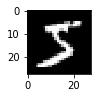

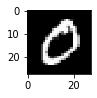

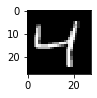

In [13]:
for i in range(3):  
  pyplot.subplot(330 + 1 + i)
  pyplot.imshow(x_train[i], cmap=pyplot.get_cmap('gray'))
  pyplot.show()

In [14]:
# expand new axis, channel axis 
x_train, x_test = np.expand_dims(x_train, axis=-1), np.expand_dims(x_test, axis=-1)
# it's always better to normalize 
x_train, x_test = x_train.astype('float32') / 255.0, x_test.astype('float32') / 255.0
# resize the input shape , i.e. old shape: 28, new shape: 32
x_train, x_test = tf.image.resize(x_train, [32,32]), tf.image.resize(x_test, [32,32]) # if we want to resize 
# one-hot 
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

In [15]:
x_train.shape

TensorShape([60000, 32, 32, 1])

In [16]:
print(x_train.shape, y_train.shape)

(60000, 32, 32, 1) (60000, 10)


In [17]:
# Batch_size
X_train, Y_train, X_val, Y_val = [], [], [], []
batch_size = 3
for i in range(0, 60, batch_size):
  start_idx, end_idx = i, i + batch_size
  X_train.append(x_train[start_idx:end_idx])
  Y_train.append(y_train[start_idx:end_idx].reshape(10, batch_size))

for i in range(0, 10, batch_size):
  start_idx, end_idx = i, i + batch_size
  X_val.append(x_test[start_idx:end_idx])
  Y_val.append(y_test[start_idx:end_idx].reshape(10, batch_size))

In [18]:
X_val[0].shape

TensorShape([3, 32, 32, 1])

In [19]:
import gc
for i in range(10):
  gc.collect()

In [20]:
x = X_val[0]

shrink = x.shape[1]//32
batch_size = x.shape[0]
print('shrink = ', shrink, 'batch_size = ', batch_size)

model = vgg16(num_classes=10, shrink=shrink)
params = sp_prop(model)
#print(params)
params.reverse()
opt = adabound(params, lr=1e-3, betas=(0.9, 0.999), final_lr=7.5e-3, gamma=1e-5,
                 eps=1e-8, weight_decay=0, amsbound=False)

y = Y_val[2]
print(y.reshape(y.shape[1], y.shape[0]))

running_loss = 0
Layers = sp_prop(model)
num_epoch = 10

for i in range(1, num_epoch + 1):

  y_true, y_preds, TR, PR = [], [], [], []
  running_loss = 0
  opt.initialize_state(params)

  for x, y in zip(X_val[2:3], Y_val[2:3]):

    out = model.forward(x, batch_size)
    loss = model.lnn3.compute_cost(out, y)
    running_loss += loss
    grads = model.backward(Layers[1:], batch_size)
    opt.step(i)

    out, y = out.reshape(out.shape[1], out.shape[0]), y.reshape(y.shape[1], y.shape[0])
    print(out)
    y_preds.extend(out)
    y_true.extend(y)

    PR.extend(np.argmax(out, axis=1))
    TR.extend(np.argmax(y, axis=1))

  
  
  y_true = np.array(y_true, dtype=np.int16)
  y_preds = np.array(y_preds, dtype=np.int16)

  print('loss = ', running_loss)
  print('f1_macro = ', f1_score(TR, PR, average='macro'))
  print('accuracy = ', accuracy_score(TR, PR))








shrink =  1 batch_size =  3
[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
[[0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
  0.03333333 0.03333333 0.03333333 0.03333333]
 [0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
  0.03333333 0.03333333 0.03333333 0.03333333]
 [0.03333333 0.03333333 0.03333333 0.03333333 0.03333333 0.03333333
  0.03333333 0.03333333 0.03333333 0.03333333]]
loss =  3.4011973816621643
f1_macro =  0.0
accuracy =  0.0
[[0.03324221 0.03324359 0.03324151 0.03355597 0.03355882 0.03355608
  0.03323048 0.0332312  0.03323006 0.03326608]
 [0.03326678 0.03326582 0.03324812 0.03324793 0.03324587 0.03321208
  0.03321336 0.03321202 0.03351328 0.03351522]
 [0.03351393 0.03327757 0.03327943 0.03327696 0.03353266 0.0335373
  0.03353347 0.03325004 0.03325152 0.03325065]]
loss =  3.3951027643174645
f1_macro =  1.0
accuracy =  1.0
[[0.03304188 0.03303894 0.03303925 0.03401269 0.03403244 0.0340